In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,SCORERS
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

## Predicting New York City energy production

**Part 1:** Follow the [instruction I](https://github.com/um-perez-alvaro/Data-Science-Practice/blob/master/Jupyter%20Notebooks/Random%20Forests/homework/Instructions%201.docx?raw=true) and [instruction II](https://github.com/um-perez-alvaro/Data-Science-Practice/blob/master/Jupyter%20Notebooks/Random%20Forests/homework/Instructions%202.docx?raw=true) documents to download the weather and energy production datasets. 
Then, run the cell below.

In [2]:
# load weather data
path = 'weather_NYC.csv' 
data = pd.read_csv(path,index_col='DATE',parse_dates=True)

# load energy consumption datasets
df_list = []
file_paths = ['load_NYC_2018.csv', 'load_NYC_2019.csv']
for file in file_paths:
    df = pd.read_csv(file, 
                     usecols = ['RTD End Time Stamp','RTD Actual Load'], 
                     index_col='RTD End Time Stamp', 
                     parse_dates=True)
    df_list.append(df) 
data['LOAD'] = pd.concat(df_list).resample('d').mean() # average energy production
data.head()

,STATION,NAME,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,...,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,LOAD
DATE,,,,,,,,,,,,,,,,,,,,,
2018-01-01,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",17.67,NaN,0.00,0.0,0.0,12,18,7,...,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1719.182034
2018-01-02,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",15.66,NaN,0.00,0.0,0.0,18,26,13,...,29.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1764.714815
2018-01-03,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",8.28,NaN,0.00,0.0,0.0,21,28,12,...,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1699.275172
2018-01-04,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",28.19,NaN,0.49,8.0,1.2,25,29,19,...,55.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1722.843750
2018-01-05,USW00094789,"JFK INTERNATIONAL AIRPORT, NY US",25.05,NaN,0.00,0.0,7.9,15,19,9,...,46.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1773.566997


**Column descriptions:**

| column | description |
| :-- | --: |
| AWND | Average wind speed |
| PGTM | Peak gust time |
| PRCP | Precipitation |
| SNOW | Snowfall |
| SNWD | Snow depth |
| TAVG | Average Temperature |
| TMAX | Maximum temperature |
| TMIN | Minimum temperature |
| WDF2 | Direction of fastest 2-minute wind |
| WDF5 | Direction of fastest 5-second wind |
| WSF2 | Fastest 2-minute wind speed |
| WSF5 | Fastest 5-second wind speed |
| WT01 | Fog, ice fog, or freezing fog (may include heavy fog) |
| WT02 | Heavy fog or heaving freezing fog (not always distinguished from fog) |
| WT03 | Thunder |
| WT04 | Ice pellets, sleet, snow pellets, or small hail |
| WT05 | Hail (may include small hail) |
| WT06 | Glaze or rime |
| WT08 | Smoke or haze |
| WT09 | Blowing or drifting snow | 
| LOAD (**target vector**) | average electricity produced (in Watts) in the CAPITAL zone (see the picture below) |

![zones](nyc_zones.png)

Text(0.5, 0, 'date')

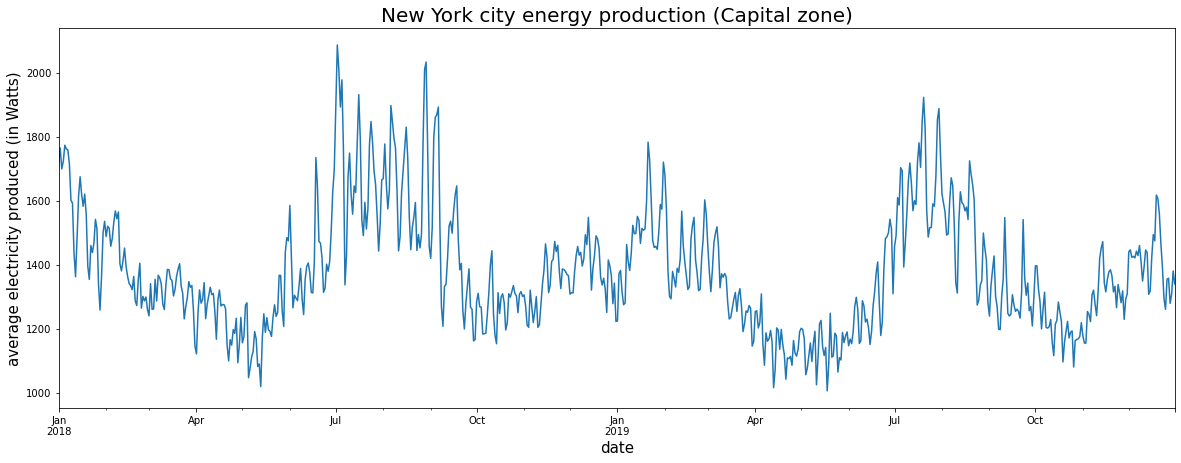

In [3]:
fig, ax = plt.subplots(figsize=(20,7))
data.LOAD.plot(ax=ax)
ax.set_title('New York city energy production (Capital zone)',fontsize=20)
ax.set_ylabel('average electricity produced (in Watts)', fontsize=15)
ax.set_xlabel('date', fontsize=15)

**Part 2:** add new columns  indicating the day of the week, the month, and whether a given date is a holiday.

In [4]:
# day of week,Month
data['Day_of_week']=data.index.dayofweek
data['month']=data.index.month
data.head()
# holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
calendar= USFederalHolidayCalendar()
holidays= calendar.holidays ('2017-10-03','2020-08-31')
data['holiday']=pd.Series(1,index=holidays)
data['holiday'].fillna(0,inplace=True)


In [5]:
data.columns

Index(['STATION', 'NAME', 'AWND', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG',
       'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03',
       'WT04', 'WT05', 'WT06', 'WT08', 'WT09', 'LOAD', 'Day_of_week', 'month',
       'holiday'],
      dtype='object')

In [6]:
data.drop(['STATION','NAME','PGTM','WDF2', 'WDF5','WSF5', 'WT01', 'WT02', 'WT03','WT04', 'WT05', 'WT06', 'WT08', 'WT09'],axis=1, inplace=True)


**Part 3:** define the matrix X and the target vector y (column `LOAD`)

In [7]:
# feature matrix/target vector
X=data.drop(['LOAD'],axis=1)
y=data.LOAD

In [8]:
X

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WSF2,Day_of_week,month,holiday
DATE,,,,,,,,,,,
2018-01-01,17.67,0.00,0.0,0.0,12,18,7,29.1,0,1,1.0
2018-01-02,15.66,0.00,0.0,0.0,18,26,13,23.0,1,1,0.0
2018-01-03,8.28,0.00,0.0,0.0,21,28,12,19.9,2,1,0.0
2018-01-04,28.19,0.49,8.0,1.2,25,29,19,44.1,3,1,0.0
2018-01-05,25.05,0.00,0.0,7.9,15,19,9,36.0,4,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,8.05,0.00,0.0,0.0,48,52,44,13.0,4,12,0.0
2019-12-28,8.50,0.00,0.0,0.0,47,52,37,15.0,5,12,0.0
2019-12-29,6.49,0.36,0.0,0.0,41,44,33,15.0,6,12,0.0


In [9]:
y

DATE
2018-01-01    1719.182034
2018-01-02    1764.714815
2018-01-03    1699.275172
2018-01-04    1722.843750
2018-01-05    1773.566997
                 ...     
2019-12-27    1358.152740
2019-12-28    1279.878125
2019-12-29    1308.771379
2019-12-30    1380.730392
2019-12-31    1340.607534
Name: LOAD, Length: 730, dtype: float64

The **goal** is to build a random forest pipeline that predicts the energy produced on a given day.
You'll train the regression model on the 2018 data, and test it on the 2019 data.

**Part 4:** Build a regression pipeline (feature preprocessor + random forest regression model). Then use a grid search to tune the pipeline hyperparameters.

In [10]:
# training - test split
X_train = X[X.index.year==2018]
y_train = y[y.index.year==2018]
X_test = X[X.index.year==2019]
y_test = y[y.index.year==2019]

In [11]:
cat_features=['Day_of_week','month','holiday']
num_features=['AWND','PRCP','SNOW','SNWD','TAVG','TMAX','TMIN','WSF2']
processor=ColumnTransformer(transformers=[
    ('cat_processor',OneHotEncoder(handle_unknown='ignore'),cat_features),
    ('num_processor',MinMaxScaler(),num_features),
])

In [12]:
# pipeline
pipe=Pipeline(steps=[
    ('processor',processor),
    ('poly_features',PolynomialFeatures(degree=2,include_bias=True)),
    ('reg', RandomForestRegressor())
])

In [13]:
# grid search
param_dic ={'reg__min_samples_split':[2,4,6,8,10],
            'reg__min_samples_leaf':[2,4,6,8],
            'reg__max_depth':[2,4,6],
            'reg__n_estimators':[2,4,6,8,10]
           }
grid=GridSearchCV(pipe,
                  param_dic,
                  cv=10,
                  scoring='neg_mean_squared_error',
                  n_jobs=-1,verbose=1)


In [14]:
grid.fit(X_train,y_train)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('processor',
                                        ColumnTransformer(transformers=[('cat_processor',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Day_of_week',
                                                                          'month',
                                                                          'holiday']),
                                                                        ('num_processor',
                                                                         MinMaxScaler(),
                                                                         ['AWND',
                                                                          'PRCP',
                                                                          'SNOW',
                                                                          'SNWD',
                                                                          'TAVG',
                                                                          'TMAX',
                                                                          'TMIN',
                                                                          'WSF2'])])),
                                       ('poly_features', PolynomialFeatures()),
                                       ('reg', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'reg__max_depth': [2, 4, 6],
                         'reg__min_samples_leaf': [2, 4, 6, 8],
                         'reg__min_samples_split': [2, 4, 6, 8, 10],
                         'reg__n_estimators': [2, 4, 6, 8, 10]},
             scoring='neg_mean_squared_error', verbose=1)

**Part 5:** Test your model on the 2019 data. 
Plot the `y_test` vector and the prediction.

In [15]:
grid.best_score_

-12913.116931065382

In [16]:
grid.best_params_

{'reg__max_depth': 6,
 'reg__min_samples_leaf': 2,
 'reg__min_samples_split': 8,
 'reg__n_estimators': 6}

In [17]:
best_pipe=grid.best_estimator_

In [18]:
data3=data[data.index.year==2019].copy()
data3['prediction']=best_pipe.predict(X_test)

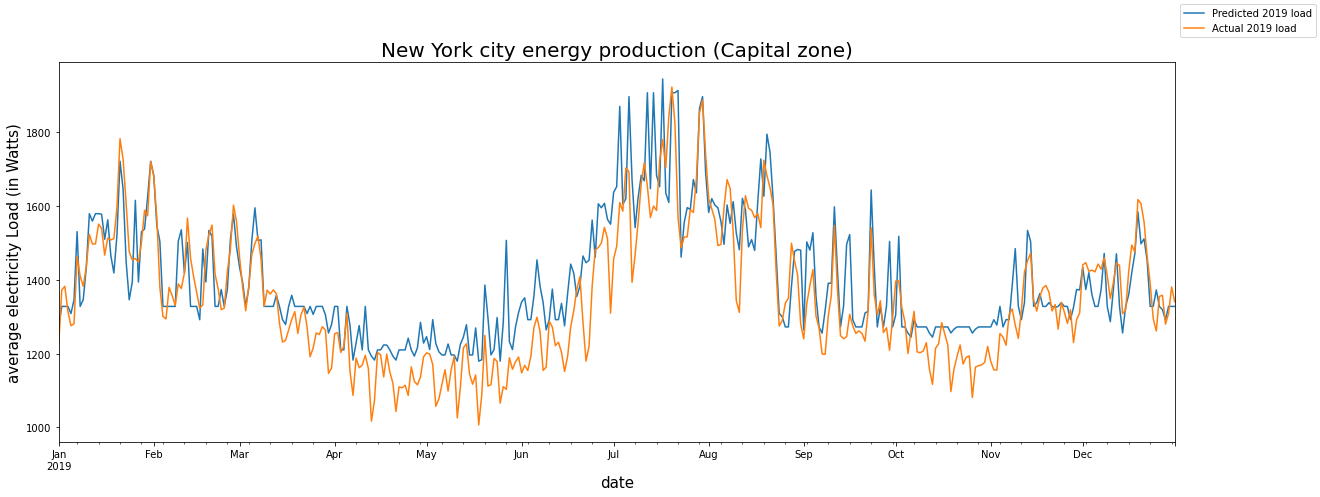

In [19]:
fig, ax = plt.subplots(figsize=(20,7))
data3['prediction'].plot(ax=ax,label='Predicted 2019 load')
data3.LOAD.plot(ax=ax,label='Actual 2019 load')


ax.set_title('New York city energy production (Capital zone)',fontsize=20)
ax.set_ylabel('average electricity Load (in Watts)', fontsize=15)
ax.set_xlabel('date', fontsize=15)
fig.legend()